# Misc
## Imports

In [1]:
import cv2 as cv
import json
import itertools
import numpy as np
import matplotlib.pyplot as plt
import sympy
import scipy.stats as sps

%matplotlib inline
plt.style.use("dark_background")

## Fixing seed

In [2]:
np.random.seed(0)

## Helper functions

In [3]:
def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

In [4]:
def save_json(path, data):
    with open(path, "w") as f:
        json.dump(data, f)

In [5]:
def draw_image(img):
    plt.figure(figsize=(10, 8))
    if img.ndim == 1:
        plt.imshow(img, cmap='gray')
    else:
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.imshow(img)
    plt.axis('off')
    plt.show()

In [6]:
def draw_lines(img, lines, color=(0, 0, 255), blank_background=False):
    img = np.zeros_like(img) if blank_background else img.copy()
    for line in lines:
        x0, y0, x1, y1 = line[0]
        img = cv.line(img, (x0, y0), (x1, y1), color, 1)
    
    draw_image(img)

# Original image

In [7]:
IMG_NAME = "14"
IMG_PATH = "images/" + IMG_NAME + ".jpg"
img = cv.imread(IMG_PATH)

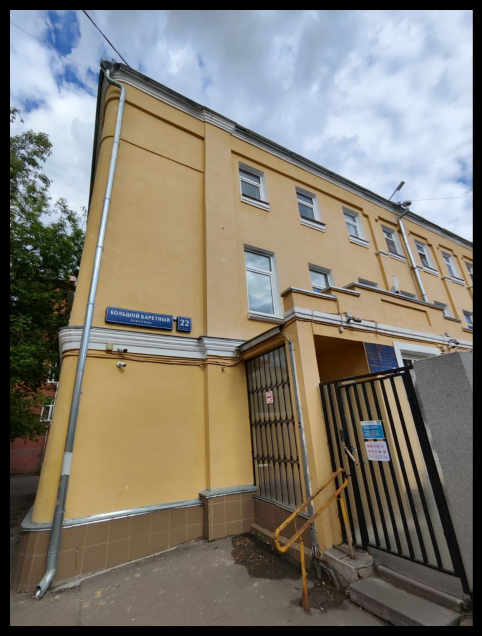

In [8]:
draw_image(img)

# Vanishing points finding
## Edge detection

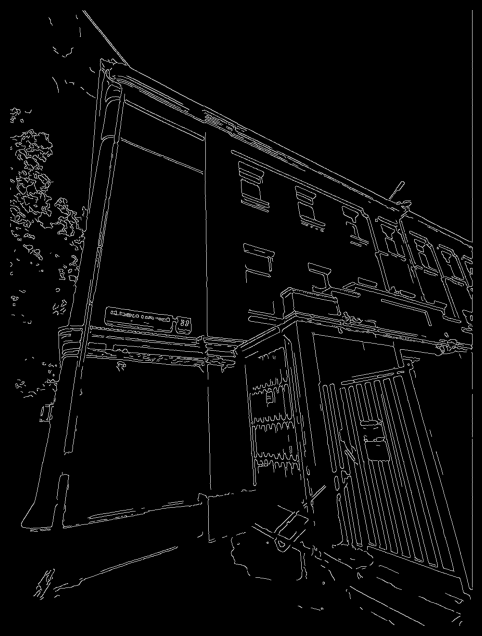

In [2558]:
CANNY_MIN_THRESH = 100
CANNY_MAX_THRESH = 150

img_grey = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_edges = cv.medianBlur(img_grey, 5)
img_edges = cv.bilateralFilter(img_edges, 5, 15, 15)
img_edges = cv.Canny(img_edges, CANNY_MIN_THRESH, CANNY_MAX_THRESH)
draw_image(img_edges)

## Appying Hough transform for lines finding

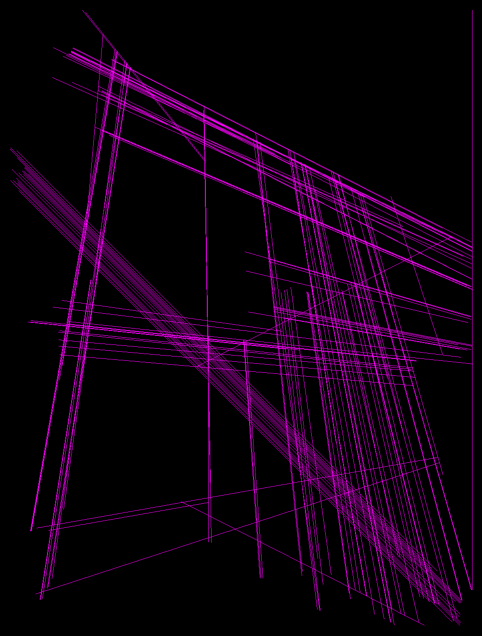

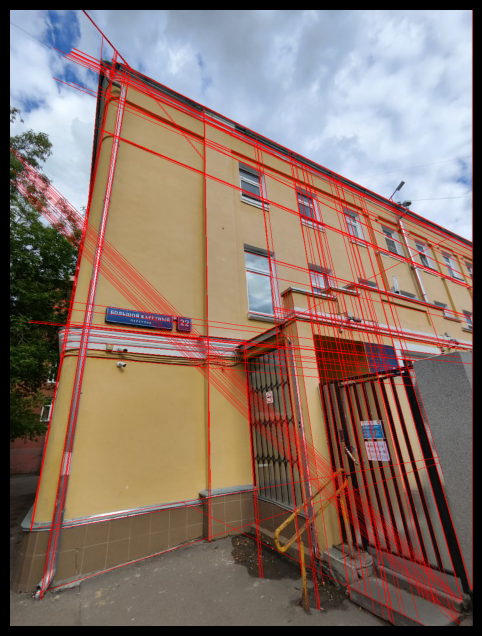

In [2559]:
HOUGH_RHO = 1
HOUGH_THETA_DEG = 1
HOUGH_THRESH = 100
HOUGH_MIN_LINE_LENGTH = 300
HOUGH_MAX_LINE_GAP = 200

lines = cv.HoughLinesP(
    img_edges,
    HOUGH_RHO,
    np.pi / 180 * HOUGH_THETA_DEG,
    HOUGH_THRESH,
    minLineLength=HOUGH_MIN_LINE_LENGTH,
    maxLineGap=HOUGH_MAX_LINE_GAP
)

draw_lines(img, lines, color=(255, 0, 255), blank_background=True)
draw_lines(img, lines, color=(0, 0, 255), blank_background=False)

## Finding vanishing points

### Making k,b plot of lines

In [2560]:
def transform_line_to_kb(line):
    x0, y0, x1, y1 = line[0]
    if x0 == x1:
        return float("inf"), x1

    k = (y0 - y1) / (x0 - x1)
    b = y0 - k * x0
    return k, b

In [2561]:
def make_kb_from_points(lines):
    kb_values = []
    for i, line in enumerate(lines):
        k, b = transform_line_to_kb(line)
        if k == float("inf"):
            continue
        kb_values.append((k, b, i))

    return np.array(kb_values)

In [2562]:
kb_values = make_kb_from_points(lines)

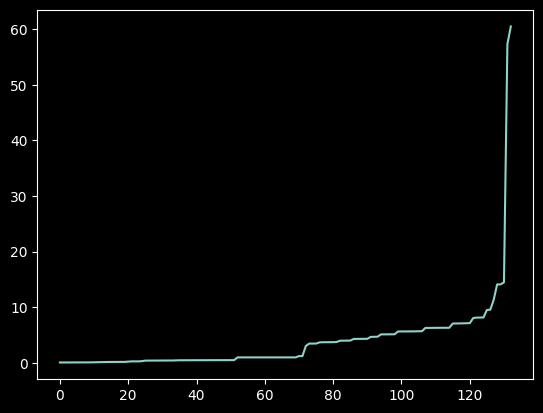

In [2563]:
plt.plot(np.sort(abs(kb_values[:, 0])))

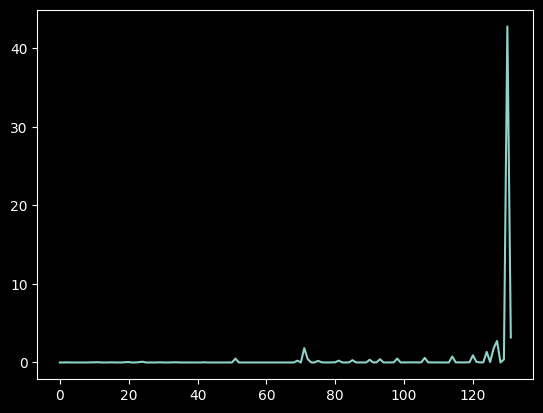

In [2564]:
differences = np.diff(np.sort(abs(kb_values[:, 0])))  
plt.plot(differences)

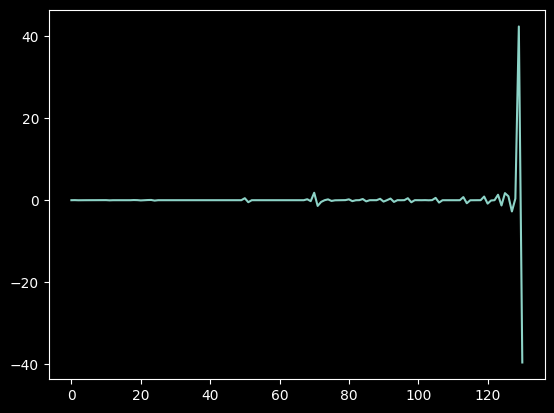

In [2565]:
diff2 = np.diff(differences)  
plt.plot(diff2)

In [2566]:
def find_first_jump(arr):
    diffs = np.diff(arr)
    
    diffs2 = np.diff(diffs)

    print(np.median(np.abs(diffs2)))
    
    sharp_indices = np.where(diffs2 / np.max(np.abs(diffs2)) > 0.0075)[0]
    # sharp_indices = np.where(diffs2 / np.median(np.abs(diffs2)) > 3.4) [0]
    
    if len(sharp_indices) == 0:
        return -1
    
    return sharp_indices[0]

In [2567]:
sorted_k = np.sort(abs(kb_values[:, 0]))

In [2568]:
jump_index = find_first_jump(sorted_k)
jump_index

0.007096894069785975


50

In [2569]:
sorted_k[jump_index]

0.5097783572359843

In [2570]:
if sorted_k[0] > 1:
    kb_horizontal = kb_values[np.abs(kb_values[:, 0]) <= 0]
    kb_vertical = kb_values[np.abs(kb_values[:, 0]) > 0]
elif sorted_k[-1]:
    kb_horizontal = kb_values[np.abs(kb_values[:, 0]) < sorted_k[jump_index]]
    kb_vertical = kb_values[np.abs(kb_values[:, 0]) > sorted_k[jump_index] + 1]

In [2571]:
def fix_emptiness(kb_values, is_vertical):
    if kb_values.shape[0] == 0:
        kb_values = np.array([[float("inf"), 100, -1]]) if is_vertical else np.array([[0, 100, -1]])

    if kb_values.shape[0] == 1:
        new_kb = np.array([[kb_values[0, 0], kb_values[0, 1] + 200, -1]])
        kb_values = np.vstack((kb_values, new_kb))

    return kb_values

In [2572]:
kb_vertical = fix_emptiness(kb_vertical, is_vertical=True)
kb_horizontal = fix_emptiness(kb_horizontal, is_vertical=False)

In [2573]:
def plot_kb_fit_plot(kb_values, slope, offset, title):
    plt.scatter(kb_values[:, 0], kb_values[:, 1])

    xs = np.array((kb_values[:, 0].min(), kb_values[:, 0].max()))
    plt.plot(xs, slope*xs + offset)
    
    plt.xlabel("$k$")
    plt.ylabel("$b$")
    plt.title(title)
    
    plt.show()

In [2574]:
def line_fit(sample):
    if np.any(np.isinf(sample[:, 0])):
        return 0, float("inf")
    if np.all(np.isclose(sample[:, 0], sample[:, 0].mean(), 1e-8)):
        return float("inf"), sample[:, 0].mean()

    return np.polyfit(sample[:, 0], sample[:, 1], 1)

In [2575]:
# def ransac_best_fit(arr):
#     best_fit_count = 0
#     best_error = float("inf")
#     best_slope, best_offset = 0, 0

#     if arr.shape[0] <= 3:
#         return line_fit(arr)
    
#     many_k = np.max(arr[:, 0]) - np.min(arr[:, 0])
#     many_b = np.max(arr[:, 1]) - np.min(arr[:, 1])

#     n = len(arr)
#     for i in range(n):
#         for j in range(i+1, n):
#             sample = arr[[i, j]]
            
#             slope, offset = line_fit(sample)

#             if np.isinf(slope):
#                 elementwise_error = (offset - arr[:, 1]) ** 2
#             else:
#                 elementwise_error = (slope * arr[:, 0] + offset - arr[:, 1]) ** 2
            
#             fit_count = np.sum(elementwise_error < (many_k**2 + many_b**2) / 4)

#             if fit_count >= len(arr) * 0.6:
#                 error = np.median(elementwise_error)
#                 if fit_count > best_fit_count or (fit_count == best_fit_count and error < best_error):
#                     best_fit_count, best_error, best_slope, best_offset = fit_count, error, slope, offset

#     return best_slope, best_offset

In [2576]:
# def ransac_best_fit(arr, sample_size=0.5, iterations=100):
#     best_error = float("inf")
#     best_slope, best_offset = 0, 0
#     n_samples = int(arr.shape[0] * sample_size)

#     if arr.shape[0] <= 3:
#         return line_fit(arr)
    
#     for _ in range(iterations):
#         ids = np.random.randint(arr.shape[0], size=n_samples)
#         sample = arr[ids]

#         fitted = sps.theilslopes(sample[:, 1], sample[:, 0])
#         slope, offset = fitted.slope, fitted.intercept

#         if np.isinf(slope):
#             elementwise_error = (offset - sample[:, 1]) ** 2
#         else:
#             elementwise_error = (slope * sample[:, 0] + offset - sample[:, 1]) ** 2
        
#         error = np.mean(elementwise_error)
#         if error < best_error:
#             best_error, best_slope, best_offset = error, slope, offset

#     return best_slope, best_offset

In [2577]:
from scipy.stats import pearsonr, spearmanr

In [2578]:
def ransac_best_fit(arr, sample_size=0.3, iterations=7000):
    best_pearson = 0
    best_slope, best_offset = 0, 0
    n_samples = int(arr.shape[0] * sample_size)

    if len(arr) <= 10:
        return line_fit(arr)
    
    print(len(arr))
    
    for _ in range(iterations):
        ids = np.random.randint(arr.shape[0], size=n_samples)
        sample = arr[ids]

        fitted = sps.theilslopes(sample[:, 1], sample[:, 0])
        slope, offset = fitted.slope, fitted.intercept

        r_pearson, _ = pearsonr(sample[:, 0], sample[:, 1])
        if abs(r_pearson) > best_pearson:
            best_slope, best_offset, best_pearson = slope, offset, abs(r_pearson)

    return best_slope, best_offset

In [2579]:
slope_vertical, offset_vertical = ransac_best_fit(kb_vertical)

61


In [2580]:
slope_horizontal, offset_horizontal = ransac_best_fit(kb_horizontal)

50


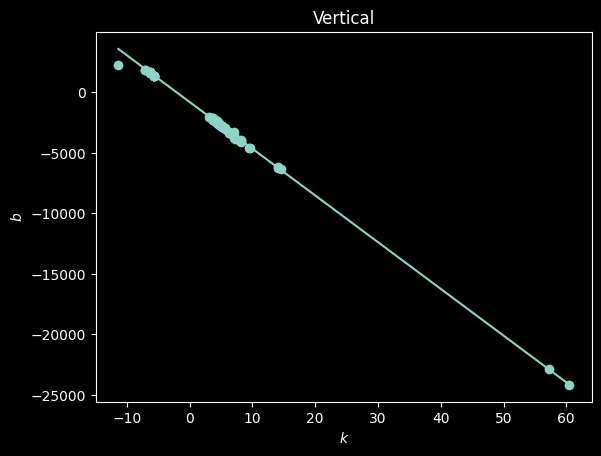

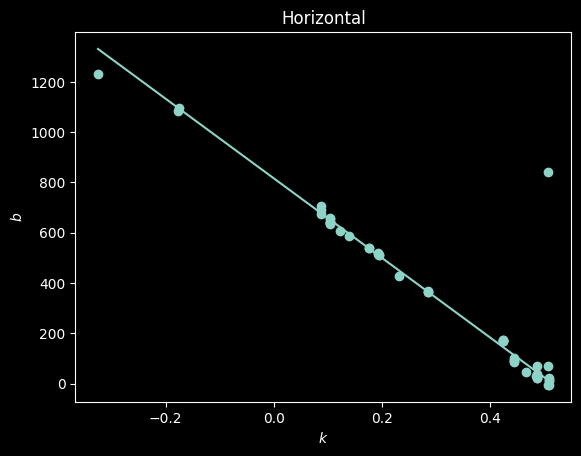

In [2581]:
plot_kb_fit_plot(kb_vertical, slope_vertical, offset_vertical, "Vertical")
plot_kb_fit_plot(kb_horizontal, slope_horizontal, offset_horizontal, "Horizontal")

### Getting vanishing points from line parameters

In [2582]:
vp_vertical = np.array((-slope_vertical, offset_vertical))
vp_horizontal = np.array((-slope_horizontal, offset_horizontal))

In [2583]:
print(f"Vertical vanishing point: {vp_vertical}")
print(f"Horizontalal vanishing point: {vp_horizontal}")

Vertical vanishing point: [ 385.80282808 -806.38064077]
Horizontalal vanishing point: [1580.26157734  816.63331599]


# Projective transform
## Getting support lines

In [2584]:
def distance_to_line(p, line):
    p = sympy.Point(p)
    line = sympy.Line(line[0, :2], line[0, 2:])
    
    return line.distance(p).evalf()

In [2585]:
def get_support_lines(lines, kb_values, vp):
    if np.any(np.isinf(vp)):
        ls = []
        for i in range(1, 3):
            if np.isinf(vp[0]):
                ls.append((100, 100*i, 200, 100*i))
            else:
                ls.append((100*i, 100, 100*i, 200))
        return np.array(ls).reshape(2, 1, 4)

    errors = np.abs(kb_values[:, 0]*vp[0] + kb_values[:, 1] - vp[1])
    min_error_ids = np.argsort(errors)
    line_ids = kb_values[min_error_ids, 2].astype(int)

    l1 = lines[line_ids[0]]

    far_point_idx = np.argmax(np.linalg.norm(l1.reshape(2, 2) - vp, axis=1))
    far_point = l1.reshape(2, 2)[far_point_idx]

    for line in lines[line_ids[1:]]:
        distance_to_l1 = distance_to_line(far_point, line)
        l2 = line
        if distance_to_l1 > 200:
            break

    return np.vstack((l1, l2)).reshape(2, 1, 4)

In [2586]:
lines_vertical = get_support_lines(lines, kb_vertical, vp_vertical)
lines_horizontal = get_support_lines(lines, kb_horizontal, vp_horizontal)

In [2587]:
print(lines_vertical)
print(lines_horizontal)

[[[ 604  316  790 1271]]

 [[  63 1224  168  560]]]
[[[131  78 959 500]]

 [[547 616 959 696]]]


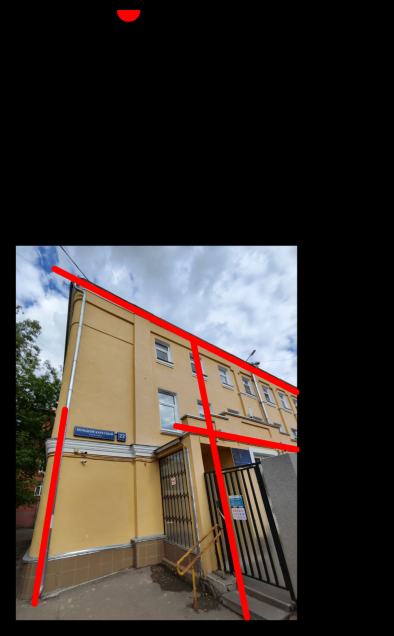

In [2588]:
vp_all = np.array((vp_vertical, vp_horizontal))
vp_all = vp_all[~np.any(np.isinf(vp_all), axis=1)].astype(int)

min_padding = 20

negative_pad = np.maximum(-vp_all.min(axis=0), min_padding)
positive_pad = np.maximum(vp_all.max(axis=0) - img.shape[:2], min_padding)

img_expanded = cv.copyMakeBorder(img, negative_pad[1], positive_pad[1], negative_pad[0], positive_pad[0], cv.BORDER_CONSTANT)
for vp in vp_all:
    vp_shifted = vp + negative_pad
    cv.circle(img_expanded, vp_shifted, min_padding*2, (0, 0, 255), -1)

for line in itertools.chain(lines_vertical, lines_horizontal):
    line_begin = line[0, :2] + negative_pad
    line_end = line[0, 2:] + negative_pad
    
    cv.line(img_expanded, line_begin, line_end, (0, 0, 255), min_padding)

draw_image(img_expanded)

## Минутка теории

Точке $(x, y)$ соответсвует множество точек вида $(X, Y, W)$, причём $x = \dfrac{X}{W}, y = \dfrac{Y}{W}$

Проективное преобразование задаётся матрицей $H$ размером $3 \times 3$:

$$
H = \begin{bmatrix}
h_{11} & h_{12} & h_{13} \\
h_{21} & h_{22} & h_{23} \\
h_{31} & h_{32} & h_{33}
\end{bmatrix}.
$$

Гомография имеет 8 степеней свободы (9 элементов матрицы, масштаб не учитывается). Для её восстановления требуется минимум 4 пары точек, то есть 8 уравнений.

Проективное преобразование для конкретной точки выглядит так:
$$
s \cdot \begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} = H \cdot \begin{bmatrix} x \\ y \\ 1 \end{bmatrix},
$$
где $s$ — произвольный скаляр (масштаб).

Отсюда:
$$
x' = \frac{h_{11}x + h_{12}y + h_{13}}{h_{31}x + h_{32}y + h_{33}}, \quad y' = \frac{h_{21}x + h_{22}y + h_{23}}{h_{31}x + h_{32}y + h_{33}}.
$$

После этого мы можем решить следующую задачу:

$$
\underbrace{\begin{bmatrix}
x_1 & y_1 & 1 & 0 & 0 & 0 & -x_1 x'_1 & -y_1 x'_1 & -x'_1 \\
0 & 0 & 0 & x_1 & y_1 & 1 & -x_1 y'_1 & -y_1 y'_1 & -y'_1 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x_4 & y_4 & 1 & 0 & 0 & 0 & -x_4 x'_4 & -y_4 x'_4 & -x'_4 \\
0 & 0 & 0 & x_4 & y_4 & 1 & -x_4 y'_4 & -y_4 y'_4 & -y'_4
\end{bmatrix}}_{A (8 \times 9)} \cdot \underbrace{\begin{bmatrix} h_{11} \\ h_{12} \\ h_{13} \\ h_{21} \\ h_{22} \\ h_{23} \\ h_{31} \\ h_{32} \\ h_{33} \end{bmatrix}}_{\mathbf{h}} = \mathbf{0}.
$$

Система $A \mathbf{h} = 0$ решается методом SVD:

$$
A = U \Sigma V^T,
$$
где:
- $ U $ — ортогональная матрица размера $ m \times m $ (столбцы $ U $ — левые сингулярные векторы),
- $ \Sigma $ — диагональная матрица размера $ m \times n $, элементы $ \sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_r > 0 $ (сингулярные значения, $ r = \text{rank}(A) $),
- $ V $ — ортогональная матрица размера $ n \times n $ (столбцы $ V $ — правые сингулярные векторы).

Система $ A \mathbf{h} = 0 $ ищет вектор ($ \mathbf{h} \neq 0 $), лежащий в ядре матрицы $ A $.  
Из SVD следует, что:
$$
A \mathbf{h} = U \Sigma V^T \mathbf{h} = 0.
$$
Так как $ U $ и $ V $ ортогональны (их столбцы ортонормированы), ядро $ A $ определяется правыми сингулярными векторами, соответствующими нулевым сингулярным значениям.

Так как ранг матрицы $A$ не превышает $8$, а число неизвестных $9$, то последний вектор матрицы $V$, который соответствует нулевому сингулярному значению, и будет решением нашего равенства (возможно, не единственным).

## Finding homography matrix

In [2589]:
def find_homography_matrix(old_points, new_points):
    A = []
    for i in range(4):
        x, y = old_points[i]
        xp, yp = new_points[i]
    
        A.append([x, y, 1, 0, 0, 0, -x*xp, -y*xp, -xp])
        A.append([0, 0, 0, x, y, 1, -x*yp, -y*yp, -yp])

    A = np.array(A)
    
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1].reshape(3, 3)
    h /= h[2, 2]

    return h

## Apply transform

In [2590]:
def apply_projective_transform(img, old_points, new_points):
    #h = cv.findHomography(old_points, new_points)
    h = find_homography_matrix(old_points, new_points)
    return cv.warpPerspective(
        src=img, 
        M=h, 
        dsize=(img.shape[1], img.shape[0]),
        flags=cv.INTER_LINEAR,
        borderMode=cv.BORDER_CONSTANT,
    )

## Finding intersections of lines

In [2591]:
def find_intersection(line1, line2):
    k1, b1 = transform_line_to_kb(line1)
    k2, b2 = transform_line_to_kb(line2)

    if k1 == k2:
        raise ValueError(f"Line are parallel with k={k1}")
        
    if k1 == float("inf"):
        x = b1
        y = k2 * x + b2
        return x, y
    elif k2 == float("inf"):
        x = b2
        y = k1 * x + b1
        return x, y

    x = (b2 - b1) / (k1 - k2)
    y = k1 * x + b1

    return x, y  

## Chosing support points

In [2592]:
def sort_points(points):
    sorted_points = sorted(points, key=lambda point: point[0])
    left = sorted_points[0:2]
    right = sorted_points[2:4]
    left = sorted(left, key=lambda left: left[1])
    right = sorted(right, key=lambda right: right[1])
    return np.array([left[0], left[1], right[0], right[1]])

In [2593]:
def find_support_points(lines_vertical, lines_horizontal):
    points = []
    for l1, l2 in itertools.product(lines_vertical, lines_horizontal):
        p = find_intersection(l1, l2)
        points.append(p)
    points = np.array(points).astype(int)
    
    points = sort_points(points)
    
    min_x, max_x = points[:, 0].min(), points[:, 0].max()
    min_y, max_y = points[:, 1].min(), points[:, 1].max()

    new_points = []
    for x, y in itertools.product((min_x, max_x), (min_y, max_y)):
        new_points.append((x, y))
    new_points = np.array(new_points)
    
    return points, new_points

In [2594]:
old_points, new_points = find_support_points(lines_vertical, lines_horizontal)

In [2595]:
old_points, new_points

(array([[235, 131],
        [170, 542],
        [604, 319],
        [666, 639]]),
 array([[170, 131],
        [170, 639],
        [666, 131],
        [666, 639]]))

## Transforming an image

In [2596]:
img_output = apply_projective_transform(img, old_points, new_points)

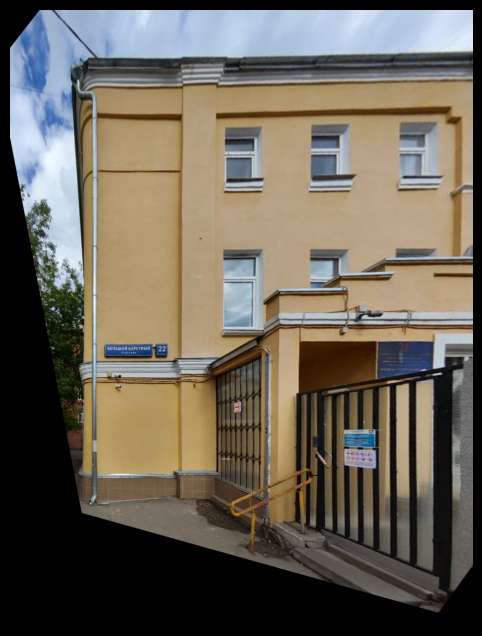

In [2597]:
draw_image(img_output)

In [ ]:
cv.imwrite(f'results/{IMG_NAME}_result.jpg', img_output)

True